In [67]:
import numpy as np
import librosa 
import librosa.display
import matplotlib.pyplot as plt

In [68]:
y, sr = librosa.load(".\\babble_16k.wav")

In [10]:
tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)
beat_times = librosa.frames_to_time(beat_frames, sr=sr)


AttributeError: '_process_plot_var_args' object has no attribute 'prop_cycler'

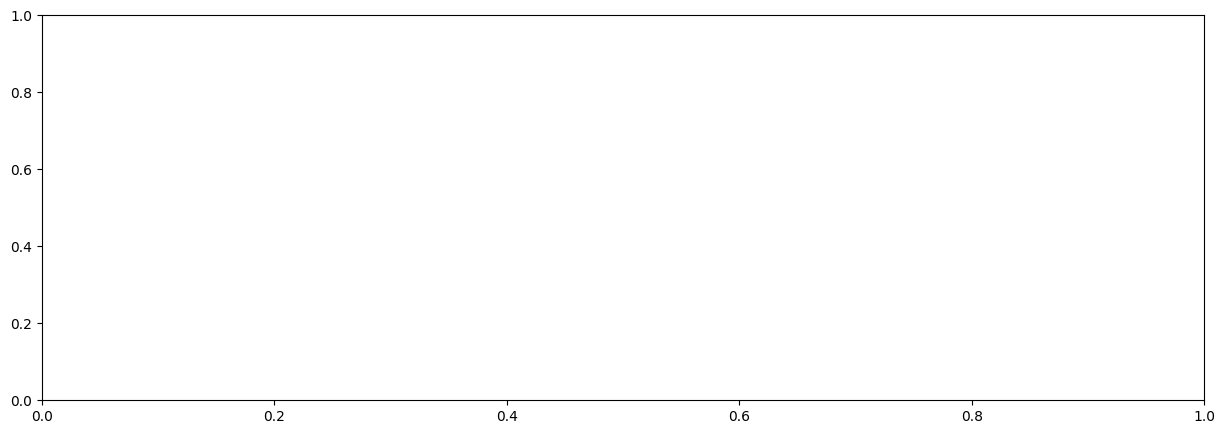

In [11]:
plt.figure(figsize=(15,5))
librosa.display.waveshow(y, sr=sr) 
plt.xlabel('time (s)') 
plt.ylabel('amplitude')
plt.title('noise signal')
plt.show()

In [ ]:
import os
data_directory = ".\\intro-disclaimers"
durations = []

def process_directory(directory):
    for item in os.listdir(directory):
        item_path = os.path.join(directory, item)

        if os.path.isdir(item_path):
            process_directory(item_path)
        
        elif item.endswith('.flac'):
            cl, sr_cl = librosa.load(item_path, sr=None)
            duration = librosa.get_duration(y=cl, sr=sr_cl)
            durations.append(duration)


process_directory(data_directory)
average_duration = sum(durations) / len(durations)
print(f"Durée moyenne des audios: {average_duration:.2f} secondes")


In [12]:

import soundfile as sf
noise_directory =".\\noise"
segment_length = int(sr * 11.28)  

for start in range(0, len(y), segment_length):
    end = start + segment_length
    segment = y[start:end]
    output_path = os.path.join(noise_directory, f'segment_{start//segment_length}.wav')

    sf.write(output_path, segment, sr)


In [13]:
from random import choice as rand_choice
import soundfile as sf
import os
from sklearn.model_selection import train_test_split

noisy_audio_directory = ".\\noisy_audio"

def process_directory(directory):
    audio_data = []

    for item in os.listdir(directory):
        item_path = os.path.join(directory, item)

        if os.path.isdir(item_path):
            audio_data.extend(process_directory(item_path))
        elif item.endswith('.flac'):
            voice, sr_voice = librosa.load(item_path, sr=None)
            audio_data.append((voice, sr_voice, item_path))  # Ajout du chemin du fichier

    return audio_data

audio_data = process_directory(data_directory)
voice_paths = []
noisy_paths = []
noise_paths = []
for voice, sr_voice, voice_path in audio_data:
    if len(voice) <= segment_length:
        noise_files = [f for f in os.listdir(noise_directory) if f.endswith('.wav')]
        random_noise_file = rand_choice(noise_files)
        noise_segment_path = os.path.join(noise_directory, random_noise_file)
        noise, sr_noise = librosa.load(noise_segment_path, sr=None)

        if sr_noise != sr_voice:
            noise = librosa.resample(noise, orig_sr=sr_noise, target_sr=sr_voice)
            sr_noise = sr_voice

        if len(voice) > len(noise):
            voice = voice[:len(noise)]
        else:
            noise = noise[:len(voice)]

        output_directory = os.path.join(noisy_audio_directory, "voice_noise_pairs")
        if not os.path.exists(output_directory):
            os.makedirs(output_directory)

        voice_directory = os.path.join(output_directory, "voice")
        if not os.path.exists(voice_directory):
            os.makedirs(voice_directory)

        noisee_directory = os.path.join(output_directory, "noise")
        if not os.path.exists(noisee_directory):
            os.makedirs(noisee_directory)

        voice_noisy_directory = os.path.join(output_directory, "voice_noisy")
        if not os.path.exists(voice_noisy_directory):
            os.makedirs(voice_noisy_directory)

        voice_output_path = os.path.join(voice_directory, f'original_{os.path.basename(voice_path)}')
        sf.write(voice_output_path, voice, sr_voice)

        noisy_output_path = os.path.join(voice_noisy_directory, f'noisy_{os.path.basename(voice_path)}')
        sf.write(noisy_output_path, voice + noise, sr_voice)

        noise_output_path = os.path.join(noisee_directory, f'noise_{os.path.basename(voice_path)}')
        sf.write(noise_output_path, noise, sr_voice)

        voice_paths.append(voice_output_path)
        noisy_paths.append(noisy_output_path)
        noise_paths.append(noise_output_path)


In [97]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

n_fft = 512
hop_length = 256

class SpeechEnhancementDNN(nn.Module):
    def __init__(self, input_size):
        super(SpeechEnhancementDNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, input_size)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x


class AudioDataset(Dataset):
    def __init__(self, voice_paths, noisy_paths, noise_paths):
        self.voice_paths = voice_paths
        self.noisy_paths = noisy_paths
        self.noise_paths = noise_paths

    def __len__(self):
        return len(self.voice_paths)

    def __getitem__(self, idx):
        voice_path, noisy_path, noise_path = self.voice_paths[idx], self.noisy_paths[idx], self.noise_paths[idx]

    
        # Charger les signaux audio et vérifier qu'ils ne sont pas vides
        voice, sr_voice = librosa.load(voice_path, sr=None)
        noisy, sr_noisy = librosa.load(noisy_path, sr=None)
        noise, sr_noise = librosa.load(noise_path, sr=None)
        
        if len(voice) == 0 or len(noisy) == 0 or len(noise) == 0:
            raise ValueError(f"Le fichier audio chargé depuis {voice_path} ou {noisy_path} ou {noise_path} est vide.")
        
        # Effectuer la STFT
        noisy_stft = librosa.stft(noisy, n_fft=n_fft, hop_length=hop_length)
        voice_stft = librosa.stft(voice, n_fft=n_fft, hop_length=hop_length)

        # S'assurer que la STFT renvoie des matrices avec deux dimensions
        if noisy_stft.ndim != 2 or voice_stft.ndim != 2:
            raise ValueError(f"La transformation STFT a échoué pour {voice_path} ou {noisy_path}.")

        # Trouver la longueur minimale pour rogner
        min_length = min(noisy_stft.shape[-1], voice_stft.shape[-1])

        # Rogner les spectrogrammes pour qu'ils aient la même longueur
        noisy_stft = noisy_stft[:, :min_length]
        voice_stft = voice_stft[:, :min_length]
        
        noisy_mag = np.abs(noisy_stft)
        noisy_log = np.log1p(noisy_mag ** 2)
        voice_mag = np.abs(voice_stft)**2

        mask = voice_mag / (voice_mag + 1e-8)  # Ajouter un epsilon pour éviter la division par zéro

        return torch.tensor(noisy_log, dtype=torch.float32), torch.tensor(mask, dtype=torch.float32)

C:\Users\DELL\AppData\Local\Temp\ipykernel_4040\2334501591.py:22: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  librosa.display.specshow(librosa.amplitude_to_db(noisy_stft, ref=np.max), y_axis='log', x_axis='time')
C:\Users\DELL\AppData\Local\Temp\ipykernel_4040\2334501591.py:30: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  librosa.display.specshow(librosa.amplitude_to_db(voice_stft, ref=np.max), y_axis='log', x_axis='time')
C:\Users\DELL\AppData\Local\Temp\ipykernel_4040\2334501591.py:36: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  librosa.display.specshow(librosa.amplitude_to_db(noise_stft, ref=np.max), y_axis='log', x_axis='ti

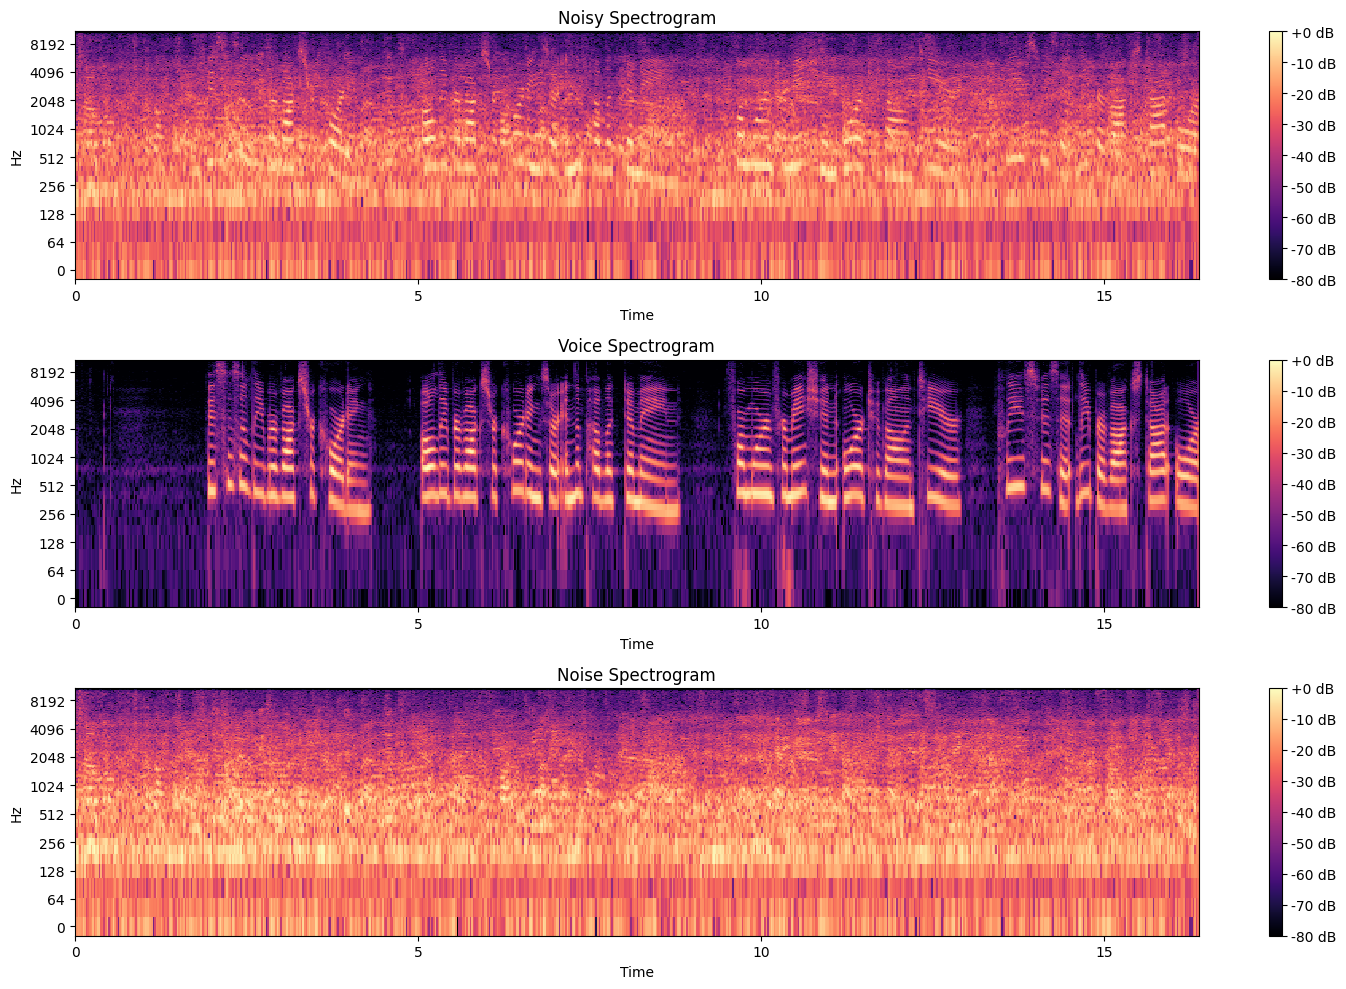

In [98]:
import matplotlib.pyplot as plt


example_index = 0
voice_path, noisy_path, noise_path = voice_paths[example_index], noisy_paths[example_index], noise_paths[example_index]


voice, sr_voice = librosa.load(voice_path, sr=None)
noisy, sr_noisy = librosa.load(noisy_path, sr=None)
noise, sr_noise = librosa.load(noise_path, sr=None)

# Calculez les spectrogrammes
noisy_stft = librosa.stft(noisy, n_fft=n_fft, hop_length=hop_length)
voice_stft = librosa.stft(voice, n_fft=n_fft, hop_length=hop_length)
noise_stft = librosa.stft(noise, n_fft=n_fft, hop_length=hop_length)

# Visualisez les spectrogrammes
plt.figure(figsize=(15, 10))

# Spectrogramme de Noisy
plt.subplot(3, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(noisy_stft, ref=np.max), y_axis='log', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Noisy Spectrogram')



# Spectrogramme de Voice
plt.subplot(3, 1, 2)
librosa.display.specshow(librosa.amplitude_to_db(voice_stft, ref=np.max), y_axis='log', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Voice Spectrogram')

# Spectrogramme de Noise
plt.subplot(3, 1, 3)
librosa.display.specshow(librosa.amplitude_to_db(noise_stft, ref=np.max), y_axis='log', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Noise Spectrogram')

plt.tight_layout()
plt.show()


In [102]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# Split des données
paths_train, paths_test = train_test_split(
    list(zip(voice_paths, noisy_paths, noise_paths)),
    test_size=0.2,
    random_state=42
)

# Décomposons les données d'entraînement
voice_paths_train, noisy_paths_train, noise_paths_train = zip(*paths_train)
voice_paths_test, noisy_paths_test, noise_paths_test = zip(*paths_test)

# Créons les ensembles de données avec les données décomposées
train_dataset = AudioDataset(voice_paths_train, noisy_paths_train, noise_paths_train)
test_dataset = AudioDataset(voice_paths_test, noisy_paths_test, noise_paths_test)

# Chargeons les ensembles de données dans des DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


In [104]:
import torch.nn.functional as F

num_epochs = 10
for epoch in range(num_epochs):
    for noisy_log, mask in train_loader:
    
        predicted_mask = model(noisy_log)
        
        # Assurez-vous que les spectrogrammes ont la même longueur
        max_length = max(noisy_log.size(1), predicted_mask.size(1), mask.size(1))

        # Rembourrez ou tronquez les spectrogrammes
        padded_noisy_log = F.pad(noisy_log, (0, max_length - noisy_log.size(1)))
        padded_predicted_mask = F.pad(predicted_mask, (0, max_length - predicted_mask.size(1)))
        padded_mask = F.pad(mask, (0, max_length - mask.size(1)))
        
        loss = loss_function(padded_predicted_mask, padded_mask)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')


RuntimeError: stack expects each tensor to be equal size, but got [257, 650] at entry 0 and [257, 706] at entry 1

In [ ]:
# Sauvegarder le modèle formé
torch.save(model.state_dict(), 'speech_enhancement_model.pth')